In [1]:
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### [Q1 10 points] Read in data

In [2]:
gold = pd.read_csv('gold.txt', sep='\t', names=['url', 'category'])
label = pd.read_csv('labels.txt', sep='\t', names=['turk', 'url', 'category'])

### [Q2 10 points] Split into two DataFrames

In [3]:
mask = label['url'].isin(gold['url'])
labels_on_gold = label[mask]
labels_unknown = label[-mask]

### [Q3 10 points] Compute accuracies of turks

In [4]:
all_rate = labels_on_gold.merge(gold, left_on = 'url', right_on = 'url', suffixes = ['_lab', '_gold'])
all_rate['correct'] = all_rate['category_lab'] == all_rate['category_gold']
rater_goodness = all_rate.groupby('turk')['correct'].agg(['mean', 'count'])
rater_goodness.iloc[:10]

,mean,count
turk,,
A112DVP1KG4QZU,1.000000,1
A1253FXHCZ9CWM,0.517241,29
A12CY1Q7XKJJDE,1.000000,1
A12RE8G66WTO8B,0.750000,20
A12Y1GTGIQDGRA,0.333333,3
A13CEW9JGDWGX1,1.000000,1
A13OE9GBRJ0S2U,0.750000,4
A14IQ4GLNWNPOJ,1.000000,1
A153PKAL7OAY36,0.722973,148


### [Q4 10 points] Odds ratios
If someone is correct p fraction of the time, the odds of success are defined
as:
Attach a column called odds to the rater goodness DataFrame, using the
average correctness of the turk as his or her p.

In [5]:
rater_goodness['odds'] = rater_goodness['mean'] / (1.001 - rater_goodness['mean'])
rater_goodness.iloc[:10]

,mean,count,odds
turk,,,
A112DVP1KG4QZU,1.000000,1,1000.000000
A1253FXHCZ9CWM,0.517241,29,1.069214
A12CY1Q7XKJJDE,1.000000,1,1000.000000
A12RE8G66WTO8B,0.750000,20,2.988048
A12Y1GTGIQDGRA,0.333333,3,0.499251
A13CEW9JGDWGX1,1.000000,1,1000.000000
A13OE9GBRJ0S2U,0.750000,4,2.988048
A14IQ4GLNWNPOJ,1.000000,1,1000.000000
A153PKAL7OAY36,0.722973,148,2.600369


### [Q5 10 points] Most accurate turks

In [6]:
mask = rater_goodness['count'] >= 20
rater_goodness[mask].sort_values(by = 'mean', ascending = False).iloc[:10]

,mean,count,odds
turk,,,
A2U0R4X38GUKZE,0.950000,20,18.627451
A22C0PJUBFJTI0,0.916667,36,10.869565
A23YQUBXZPKILZ,0.875000,24,6.944444
ATVALOQVDCMZW,0.854369,103,5.826657
A1HIXWH4OXT8S4,0.825000,40,4.687500
A3220HG1O83HQ4,0.818182,22,4.475385
A32W20KGQXS0LL,0.800000,25,3.980100
A20PWAB7G3HDHU,0.800000,20,3.980100
AJSJVK40F5HM6,0.785714,28,3.649635


### [Q6 10 points] Rating counts versus accuracy

In [7]:
# showing through linear regression
y, X = dmatrices('mean ~ count', data = rater_goodness, return_type = 'dataframe')
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5488
Date:                Tue, 03 Aug 2021   Prob (F-statistic):              0.459
Time:                        10:03:51   Log-Likelihood:                -94.663
No. Observations:                 269   AIC:                             193.3
Df Residuals:                     267   BIC:                             200.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6431      0.024     27.071      0.000       0.596       0.690
count          0.0007      0.001      0.741      0.459      -0.001       0.002
==============================================================================
Omnibus:                       29.253   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.396
Skew:                          -0.731   Prob(JB):                     6.82e-07
Kurtosis:                       2.373   Cond. No.                         30.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The number of ratings does not have a significant effect the accuracy of the rating (p > .05).

<AxesSubplot:title={'center':'Avg label count for turks with different odds/ success rate'}, xlabel='odd_bins'>

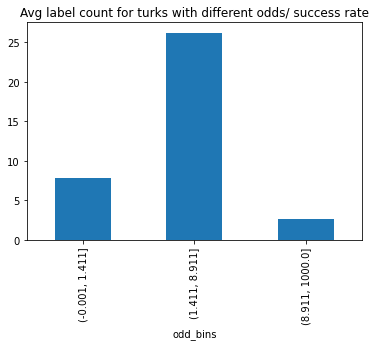

In [8]:
# showing through qcut
rater_goodness['odd_bins'] = pd.qcut(rater_goodness['odds'], q = 3)

rater_goodness.groupby('odd_bins')['count'].\
                                        mean().\
                                        plot(kind = 'bar',
                                            title = "Avg label count for turks with different odds/ success rate")

Turks with high odds(>9) seems to be rating less than "typical" number of urls.
<br>Turks with odds with odds between 1.411 and 8.911 seem to be doing the bulk of labelling

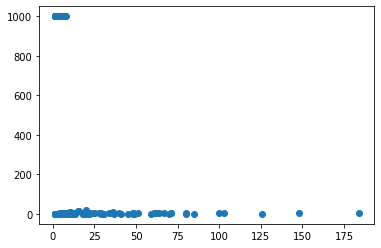

In [9]:
# shown through plots
plt.scatter(rater_goodness['count'], rater_goodness['odds'])

### [Q7 13 points] Overall predicted odds
Consider each url u that is not in the gold set, and each category c. For the pair (u, c), calculate the product of odds of all turks who (a) rated url u as category c, and (b) have rated more gold set urls than 75% of all turks who rated at least one gold-set url.
For example, if you find that there are 269 turks who rated at least one gold-set url, you want to select only the turks who have rated more gold-set urls than 75% of these 269 turks. We can think of these as our “reliable” turks. Now, our belief that url u belongs to category c depends on how many “reliable” turks rated u as c; specifically, our belief is based on the product of their reliability scores (i.e., their odds).
We shall call such products of odds the overall odds henceforth

In [10]:
# get count of ratings from > 75%
greater = rater_goodness['count'].quantile(q = .75)

# mask if grater than 75%
mask1 = rater_goodness['count'] > greater
mask2 = rater_goodness[mask1]
reliable = labels_unknown[labels_unknown['turk'].isin(mask2.index)]

# merge with rater goodness
unknown = reliable.merge(rater_goodness, left_on = 'turk', right_on = 'turk')

# calculate product of odds
print(unknown.groupby(['url', 'category'])['odds'].prod())

# made pivot table as well to easier create results
unknown = pd.pivot_table(unknown, index = "url", columns = "category", values = "odds", aggfunc = "prod")

url                          category
http://0-101.net             G            2.155963
http://000.cc                G            1.460583
http://0000.jp               G           14.488244
http://000relationships.com  G            5.681060
                             P            1.851852
                                           ...    
http://zynga.com             G            3.704611
http://zz868.com             G            1.047852
                             P            1.851852
http://zzx.cc                G            1.330229
                             X            1.620746
Name: odds, Length: 13983, dtype: float64


### [Q8 13 points] Predicted categories

In [11]:
result_75 = DataFrame(index = unknown.index)
result_75['top category'] = unknown.T.idxmax()
result_75['top odds'] = unknown.max(axis = 1)
result_75.iloc[:10]

,top category,top odds
url,,
http://0-101.net,G,2.155963
http://000.cc,G,1.460583
http://0000.jp,G,14.488244
http://000relationships.com,G,5.681060
http://000vitamins.com,G,3.784982
http://000webhost.com,G,11.159502
http://003my.com,G,4.912040
http://007absolutehardcore.com/early_cumshots/index.html,X,293.252871
http://007swz.cn,G,1.393883


### [Q9 14 points] Predicted categories using more turks
Questions 7 and 8 above only considered the ratings of turks who had rated enough gold set URLs, so we were relatively more confident about their accuracies. What happens if we loosen this restriction?
Repeat the code of Q7 and Q8, but replacing 75% by 25% in the descrip- tion of Q7 (i.e., we also consider turks who have far fewer gold set ratings). Call this result 25.
Now let’s see how these two results compare. Create a DataFrame where both the index and the columns are the various categories, and the cells
contain the number of urls with these as the top categories according to result 75 and result 25.
For example, the cell corresponding to the row category=R and the col- umn category=G would be the number of URLs that were predicted to be R by result 75 but predicted to be G by result 25.
Where are the most errors?

In [12]:
# get count of ratings from > 25%
greater = rater_goodness['count'].quantile(q = .25)

# mask if grater than 75%
mask1 = rater_goodness['count'] > greater
mask2 = rater_goodness[mask1]
reliable = labels_unknown[labels_unknown['turk'].isin(mask2.index)]

# merge with rater goodness
unknown = reliable.merge(rater_goodness, left_on = 'turk', right_on = 'turk')

# calculate product of odds
unknown = pd.pivot_table(unknown, index = "url", columns = "category", values = "odds", aggfunc = "prod")

result_25 = DataFrame(index = unknown.index)
result_25['top category'] = unknown.T.idxmax()
result_25['top odds'] = unknown.max(axis = 1)


# join 25 and 75
all_cats = result_25.join(result_75, lsuffix = '_25', rsuffix = '_75')

# crosstab
pd.crosstab(index = all_cats['top category_75'], columns = all_cats['top category_25'], margins = True)

top category_25,G,P,R,X,All
top category_75,,,,,
G,8327,574,186,216,9303
P,189,328,47,19,583
R,21,34,128,25,208
X,27,6,26,457,516
All,8564,942,387,717,10610
